In [1]:
%load_ext autoreload
%autoreload 2

import h5py
import scipy
import sympy
import pickle
import numpy as np
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sympy import Symbol, zeros, Function, MatrixSymbol

# import created modules
from hamiltonian.states import CoupledBasisState
from hamiltonian.generate_hamiltonian import generate_X_hamiltonian_function, generate_B_hamiltonian_function, \
                                                generate_diagonalized_hamiltonian
from hamiltonian.utils import ni_range, matrix_to_states, find_exact_states, reduced_basis_hamiltonian, \
                                find_state_idx_from_state, reorder_evecs, generate_coupled_ground_states

from couplings.utils import ED_ME_mixed_state, collapse_matrices, generate_superoperator, \
                            generate_flat_superoperator, generate_sharp_superoperator
from couplings.generate_coupling import optical_coupling_matrix, generate_laser_D

from symbolic import generate_density_matrix_symbolic, generate_system_of_equations, generate_symbolic_hamiltonian,\
                        system_of_equations_to_lines, generate_symbolic_detunings
from symbolic.utils import subs_rabi_rate

from utils.plot_utils import set_fontsize
from utils import population, J_levels, J_slice, delete_J_level

In [2]:
script_dir = Path().parent.absolute()

## X-state

Define what states from the $X ^1\Sigma$ electronic state are to be included in the simulation.

In [3]:
Js_g = [1] # J values to be included

parity = lambda J: (-1)**J

# generate a list of approximate ground states
# ground_states_approx = generate_coupled_ground_states(Js_g, electronic_state = 'X',
#                                                        parity = parity, Ω = 0, I_Tl = 1/2, 
#                                                        I_F = 1/2)
# ground_states_approx = [1*state for state in ground_states_approx]

I_F = 1/2
I_Tl = 1/2

# define what states are to be included in the simulation
# specify J, F1 and F for each state separately
J_ground = [1,1,1,1]
F1_ground = [1/2,1/2,3/2,3/2]
F_ground = [0,1,1,2]
# J_ground = [1]
# F1_ground = [1/2]
# F_ground = [1]

# generate a list of excited states. The exact excited states are determined within the main
# simulation function
ground_states_approx = [1*CoupledBasisState(F,mF,F1,J,I_F,I_Tl, electronic_state='X', P = (-1**J), Omega = 0)
                  for J,F1,F in zip(J_ground, F1_ground, F_ground)
                  for mF in ni_range(-F, F+1)
                 ]

In [4]:
for s in ground_states_approx:
    s.print_state()

+1.0000+0.0000j x |X, J = 1, F1 = 1/2, F = 0, mF = 0, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
+1.0000+0.0000j x |X, J = 1, F1 = 1/2, F = 1, mF = -1, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
+1.0000+0.0000j x |X, J = 1, F1 = 1/2, F = 1, mF = 0, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
+1.0000+0.0000j x |X, J = 1, F1 = 1/2, F = 1, mF = 1, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
+1.0000+0.0000j x |X, J = 1, F1 = 3/2, F = 1, mF = -1, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
+1.0000+0.0000j x |X, J = 1, F1 = 3/2, F = 1, mF = 0, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
+1.0000+0.0000j x |X, J = 1, F1 = 3/2, F = 1, mF = 1, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
+1.0000+0.0000j x |X, J = 1, F1 = 3/2, F = 2, mF = -2, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
+1.0000+0.0000j x |X, J = 1, F1 = 3/2, F = 2, mF = -1, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
+1.0000+0.0000j x |X, J = 1, F1 = 3/2, F = 2, mF = 0, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
+1.0000+0.0000j x |X, J = 1, F1 = 3/2, F = 2, mF = 1, I1 = 1/2, I2

Now generate the J=0 to J=4 Hamiltonian to get the reduced X state Hamiltonian

In [5]:
fname_X = "TlF_X_state_hamiltonian_J0to4.pickle"
fname_transform = "UC_to_C_J0to4.pickle"

path_X = script_dir / "stored_data" / fname_X
path_transform = script_dir / "stored_data" / fname_transform

with open(path_X, 'rb') as f:
    H_X_uc = pickle.load(f)

with open(path_transform, 'rb') as f:
    S_transform = pickle.load(f)

H_X_uc = generate_X_hamiltonian_function(H_X_uc)

In [6]:
# generate coupled basis states
Jmin = 0
Jmax = 4
QN_X = generate_coupled_ground_states(ni_range(Jmin, Jmax + 1), electronic_state = 'X',
                                       parity = parity, Ω = 0, I_Tl = 1/2, 
                                       I_F = 1/2)

E = np.array([0,0,0])
# small magnetic field to ensure m_F is a good quantum number
B = np.array([0,0,0.001])

H_X = S_transform.conj().T @ H_X_uc(E,B) @ S_transform

# diagonalize the Hamiltonian
H_X_diag, V, V_ref_X = generate_diagonalized_hamiltonian(H_X, keep_order = True, return_V_ref = True)

# new set of quantum numbers:
QN_X_diag = matrix_to_states(V, QN_X)

ground_states = find_exact_states(ground_states_approx, H_X_diag, QN_X_diag, V_ref = V_ref_X)

H_X_red = reduced_basis_hamiltonian(QN_X_diag, H_X_diag, ground_states)

## B-state
Define what states from the $B ^3\Pi_1$ electronic state are to be included in the simulation. Only need the states that are coupled to J = 1 in the X-state by the laser.

In [7]:
I_F = 1/2
I_Tl = 1/2

# define what states are to be included in the simulation
# specify J, F1 and F for each state separately
J_excited = [1, 1]
F1_excited = [1/2, 1/2]
F_excited = [0, 1]

# generate a list of excited states. The exact excited states are determined within the main
# simulation function
excited_states_approx = [1*CoupledBasisState(F,mF,F1,J,I_F,I_Tl, electronic_state='B', P = 1, Omega = 1)
                  for J,F1,F in zip(J_excited, F1_excited, F_excited)
                  for mF in ni_range(-F, F+1)
                 ]

Now generate the excited state Hamiltonian to get the reduced B state Hamiltonian

In [8]:
fname_B = "B_hamiltonians_symbolic_coupled_P_1to3.pickle"

path_B = script_dir / "stored_data" / fname_B

In [9]:
with open(path_B, 'rb') as f:
    H_B = pickle.load(f)

In [10]:
H_B = generate_B_hamiltonian_function(H_B)*2*np.pi

# generate coupled basis states
Jmin = 1
Jmax = 3
Ps = [-1,1]

QN_B = [CoupledBasisState(
                    F,mF,F1,J,I_F,I_Tl,P = P, Omega = 1, electronic_state='B'
                    )
        for J  in ni_range(Jmin, Jmax+1)
        for F1 in ni_range(np.abs(J-I_F),J+I_F+1)
        for F in ni_range(np.abs(F1-I_Tl),F1+I_Tl+1)
        for mF in ni_range(-F, F+1)
        for P in Ps
    ]


H_B_diag, V, V_ref_B = generate_diagonalized_hamiltonian(H_B, keep_order = True, return_V_ref = True)

# new set of quantum numbers:
QN_B_diag = matrix_to_states(V, QN_B)

excited_states = find_exact_states(excited_states_approx, H_B_diag, QN_B_diag, V_ref=V_ref_B)

H_B_red = reduced_basis_hamiltonian(QN_B_diag, H_B_diag, excited_states)

## Total Internal Hamiltonian

In [11]:
H_X_red[np.abs(H_X_red) < 0.1] = 0
H_B_red[np.abs(H_B_red) < 0.1] = 0

H_int = scipy.linalg.block_diag(H_X_red, H_B_red)
V_ref_int = np.eye(H_int.shape[0])

#Define Hamiltonian in the rotating frame (transformation not applied yet)
H_rot = H_int.copy()

#Define QN for the total Hamiltonian that includes both X and B
QN = ground_states + excited_states

## Laser coupling
### Calculating transition 1; Q(1), F$_1$'=1/2, F'=0

In [12]:
#Define ground states for laser driven transition
Js = [1]
ground_states_laser_approx =  [1*CoupledBasisState(F,mF,F1,J,I_F,I_Tl, electronic_state='X', P = (-1)**J, Omega = 0)
                                  for J  in Js
                                  for F1 in ni_range(np.abs(J-I_F),J+I_F+1)
                                  for F in ni_range(np.abs(F1-I_Tl),F1+I_Tl+1)
                                  for mF in ni_range(-F, F+1)
                                 ]

#Define excited states for laser
# excited_states_laser_approx = [1*CoupledBasisState(
#                                 F=0,mF=0,F1=1/2,J=1,I1=1/2,I2=1/2,P = +1, Omega = 1, electronic_state='B'
#                                 )
#                             ]
excited_states_laser_approx = excited_states_approx

In [13]:
#Define the "main" states. These are used to calculate the detunings and Rabi rates for the transitions
ground_main_approx = 1*CoupledBasisState(J=1,F1=3/2,F=1,mF=0,I1=1/2,I2=1/2,electronic_state='X', P = -1, Omega = 0)
excited_main_approx = 1*CoupledBasisState(J=1,F1=1/2,F=0,mF=0,I1=1/2,I2=1/2, electronic_state='B', P = +1, Omega = 1)

In [14]:
ground_states_laser_1 = find_exact_states(
                                ground_states_laser_approx, H_rot, QN, V_ref = V_ref_int
                                )
excited_states_laser_1 = find_exact_states(
                                excited_states_laser_approx, H_rot, QN, V_ref = V_ref_int
                                )

# remove the F'=1 states, they are 560 MHz away and will only add clutter to the matrix
excited_states_laser_1 = [excited_states_laser_1[0]]

H_laser_z_1 = optical_coupling_matrix(
                                    QN, 
                                    ground_states_laser_1, 
                                    excited_states_laser_1, 
                                    pol_vec = np.array([0,0,1]), 
                                    reduced = False
                                    )
H_laser_x_1 = optical_coupling_matrix(
                                    QN, 
                                    ground_states_laser_1, 
                                    excited_states_laser_1, 
                                    pol_vec = np.array([1,0,0]), 
                                    reduced = False
                                    )

In [15]:
# set small values to zero
H_laser_z_1[np.abs(H_laser_z_1) < 1e-3*np.max(np.abs(H_laser_z_1))] = 0
H_laser_x_1[np.abs(H_laser_x_1) < 1e-3*np.max(np.abs(H_laser_x_1))] = 0

In [16]:
ground_main_1 = find_exact_states([ground_main_approx], H_rot, QN, V_ref = V_ref_int)[0]
excited_main_1 = find_exact_states([excited_main_approx], H_rot, QN, V_ref = V_ref_int)[0]

ME_main_1 = ED_ME_mixed_state(
                        excited_main_1, ground_main_1, pol_vec = np.array([0,0,1])
                        )

ground_main_idx_1 = QN.index(ground_main_1)
excited_main_idx_1 = QN.index(excited_main_1)

print(ME_main_1)
ground_main_approx.print_state()
print('-'*100)
ground_main_1.print_state()
print('='*100)
excited_main_approx.print_state()
print('-'*100)
excited_main_1.print_state()

(-0.29025602182508786+0j)
+1.0000+0.0000j x |X, J = 1, F1 = 3/2, F = 1, mF = 0, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
----------------------------------------------------------------------------------------------------
+0.9961+0.0000j x |X, J = 1, F1 = 3/2, F = 1, mF = 0, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
+1.0000+0.0000j x |B, J = 1, F1 = 1/2, F = 0, mF = 0, I1 = 1/2, I2 = 1/2, P = 1, Omega = 1>
----------------------------------------------------------------------------------------------------
+1.0000+0.0000j x |B, J = 1, F1 = 1/2, F = 0, mF = 0, I1 = 1/2, I2 = 1/2, P = 1, Omega = 1>


In [100]:
for s in ground_states_laser_1:
    s.print_state()

+1.0000+0.0000j x |X, J = 1, F1 = 1/2, F = 0, mF = 0, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
+0.9961-0.0000j x |X, J = 1, F1 = 1/2, F = 1, mF = -1, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
+0.9961-0.0000j x |X, J = 1, F1 = 1/2, F = 1, mF = 0, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
+0.9961+0.0000j x |X, J = 1, F1 = 1/2, F = 1, mF = 1, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
+0.9961-0.0000j x |X, J = 1, F1 = 3/2, F = 1, mF = -1, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
+0.9961+0.0000j x |X, J = 1, F1 = 3/2, F = 1, mF = 0, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
+0.9961-0.0000j x |X, J = 1, F1 = 3/2, F = 1, mF = 1, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
+1.0000-0.0000j x |X, J = 1, F1 = 3/2, F = 2, mF = -2, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
+1.0000-0.0000j x |X, J = 1, F1 = 3/2, F = 2, mF = -1, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
+1.0000+0.0000j x |X, J = 1, F1 = 3/2, F = 2, mF = 0, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
+1.0000+0.0000j x |X, J = 1, F1 = 3/2, F = 2, mF = 1, I1 = 1/2, I2

In [17]:
for s in excited_states_laser_1:
    s.print_state()

+1.0000+0.0000j x |B, J = 1, F1 = 1/2, F = 0, mF = 0, I1 = 1/2, I2 = 1/2, P = 1, Omega = 1>


In [18]:
D1 = generate_laser_D(H_rot, QN, ground_main_1, excited_main_1, excited_states_laser_1, Δ = 0)

### Calculating transition 1; Q(1), F$_1$'=1/2, F'=1

In [19]:
#Define ground states for laser driven transition
Js = [1]
ground_states_laser_approx =  [1*CoupledBasisState(F,mF,F1,J,I_F,I_Tl, electronic_state='X', P = (-1)**J, Omega = 0)
                                  for J  in Js
                                  for F1 in ni_range(np.abs(J-I_F),J+I_F+1)
                                  for F in ni_range(np.abs(F1-I_Tl),F1+I_Tl+1)
                                  for mF in ni_range(-F, F+1)
                                 ]

#Define excited states for laser
excited_states_laser_approx = [1*CoupledBasisState(
                                F=1,mF=mF,F1=1/2,J=1,I1=1/2,I2=1/2,P = +1, Omega = 1, electronic_state='B'
                                )
                               for mF in range(-1,1+1)
                            ]

In [20]:
#Define the "main" states. These are used to calculate the detunings and Rabi rates for the transitions
ground_main_approx = 1*CoupledBasisState(J=1,F1=3/2,F=2,mF=0,I1=1/2,I2=1/2,electronic_state='X', P = -1, Omega = 0)
excited_main_approx = 1*CoupledBasisState(J=1,F1=1/2,F=1,mF=0,I1=1/2,I2=1/2, electronic_state='B', P = 1, Omega = 1)

In [21]:
ground_states_laser_2 = find_exact_states(
                                ground_states_laser_approx, H_rot, QN, V_ref = V_ref_int
                                )
excited_states_laser_2 = find_exact_states(
                                excited_states_laser_approx, H_rot, QN, V_ref = V_ref_int
                                )

H_laser_z_2 = optical_coupling_matrix(
                                    QN, 
                                    ground_states_laser_2, 
                                    excited_states_laser_2, 
                                    pol_vec = np.array([0,0,1]), 
                                    reduced = False
                                    )
H_laser_x_2 = optical_coupling_matrix(
                                    QN, 
                                    ground_states_laser_2, 
                                    excited_states_laser_2, 
                                    pol_vec = np.array([1,0,0]), 
                                    reduced = False
                                    )

In [22]:
# set small values to zero
H_laser_z_2[np.abs(H_laser_z_2) < 1e-3*np.max(np.abs(H_laser_z_2))] = 0
H_laser_x_2[np.abs(H_laser_x_2) < 1e-3*np.max(np.abs(H_laser_z_2))] = 0

In [23]:
ground_main_2 = find_exact_states([ground_main_approx], H_rot, QN, V_ref = V_ref_int)[0]
excited_main_2 = find_exact_states([excited_main_approx], H_rot, QN, V_ref = V_ref_int)[0]

ME_main_2 = ED_ME_mixed_state(
                        excited_main_2, ground_main_2, pol_vec = np.array([0,0,1])
                        )

ground_main_idx_2 = QN.index(ground_main_2)
excited_main_idx_2 = QN.index(excited_main_2)

print(ME_main_1)
ground_main_approx.print_state()
print('-'*100)
ground_main_2.print_state()
print('='*100)
excited_main_approx.print_state()
print('-'*100)
excited_main_2.print_state()

(-0.29025602182508786+0j)
+1.0000+0.0000j x |X, J = 1, F1 = 3/2, F = 2, mF = 0, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
----------------------------------------------------------------------------------------------------
+1.0000+0.0000j x |X, J = 1, F1 = 3/2, F = 2, mF = 0, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
+1.0000+0.0000j x |B, J = 1, F1 = 1/2, F = 1, mF = 0, I1 = 1/2, I2 = 1/2, P = 1, Omega = 1>
----------------------------------------------------------------------------------------------------
+0.9996+0.0000j x |B, J = 1, F1 = 1/2, F = 1, mF = 0, I1 = 1/2, I2 = 1/2, P = 1, Omega = 1>


In [24]:
for s in excited_states_laser_2:
    s.print_state()

+0.9996+0.0000j x |B, J = 1, F1 = 1/2, F = 1, mF = -1, I1 = 1/2, I2 = 1/2, P = 1, Omega = 1>
+0.9996+0.0000j x |B, J = 1, F1 = 1/2, F = 1, mF = 0, I1 = 1/2, I2 = 1/2, P = 1, Omega = 1>
+0.9996+0.0000j x |B, J = 1, F1 = 1/2, F = 1, mF = 1, I1 = 1/2, I2 = 1/2, P = 1, Omega = 1>


In [25]:
D2 = generate_laser_D(H_rot, QN, ground_main_2, excited_main_2, excited_states_laser_2, Δ = 0)

## Total Hamiltonian

In [26]:
H_rot = H_rot  - np.eye(H_rot.shape[0])*H_rot[ground_main_idx_1,ground_main_idx_1]
H_rot = H_rot + D1 + D2

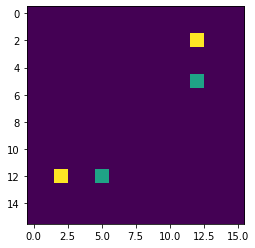

In [27]:
plt.imshow(H_laser_z_1.real)

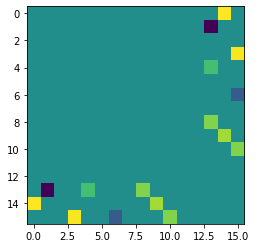

In [101]:
plt.imshow(H_laser_z_2.real)

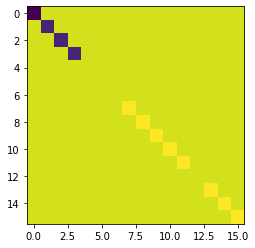

In [28]:
plt.imshow(H_rot.real)

In [30]:
np.diag(H_rot.real)/(2*np.pi*1e3)

array([-1.98191218e+02, -1.75950732e+02, -1.75952434e+02, -1.75954138e+02,
       -2.84160155e-05,  0.00000000e+00,  2.85082989e-05,  1.45420619e+01,
        1.45404224e+01,  1.45387829e+01,  1.45371433e+01,  1.45355036e+01,
        0.00000000e+00,  1.45377829e+01,  1.45387829e+01,  1.45397829e+01])

In [31]:
Γ = 2*np.pi*1.6e6
C_list = collapse_matrices(QN, ground_states, excited_states, gamma = Γ)
C_array = np.array(C_list)
C_conj_array = np.einsum('ijk->ikj', C_array.conj())

 50%|██████████████████████████████████████████                                          | 2/4 [00:00<00:00, 16.28it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 12.98it/s]


In [39]:
t = Symbol("t", real = True)
Px1 = Function("Px1")(t) # Polarization switching function for x
Pz1 = Function("Pz1")(t) # Polarization switching function for z
Px2 = Function("Px2")(t) # Polarization switching function for x
Pz2 = Function("Pz2")(t) # Polarization switching function for z

# laser_fields = [(H_laser_z_1*Pz1, ME_main_1), (H_laser_x_1*Px1, ME_main_1), 
#                 (H_laser_z_2*Pz2, ME_main_2), (H_laser_x_2*Px2, ME_main_2)]
laser_fields = [(H_laser_z_1*Pz1, ME_main_1), (H_laser_z_2*Pz2, ME_main_2)]

detunings = [[QN.index(excited_states[0])], [QN.index(excited_states[idx]) for idx in [1,2,3]]]

In [40]:
n_states = H_laser_z_1.shape[0]
excited_state_indices = [QN.index(exc_state) for exc_state in excited_states]
H_symbolic, Ωs = generate_symbolic_hamiltonian(n_states, laser_fields)
Δ_symbolic, Δs = generate_symbolic_detunings(n_states, detunings)
H_symbolic += Δ_symbolic + H_rot

In [41]:
H_symbolic

Matrix([
[            -1245272.14598083,                            0,                             0,                             0,                             0,               0,                            0,                0,                             0,               0,                             0,                0,                            0,                            0, -0.688943961004228*Ω2*Pz2(t),                            0],
[                            0,            -1105531.05151367,                             0,                             0,                             0,               0,                            0,                0,                             0,               0,                             0,                0,                            0,  0.674428203801002*Ω2*Pz2(t),                            0,                            0],
[                            0,                            0,             -1105541.75038147,                       

In [42]:
system = generate_system_of_equations(H_symbolic, C_array, progress = True)

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:14<00:00,  2.05it/s]


In [43]:
# convert matrix to system of equations code
code_lines = system_of_equations_to_lines(system)

# Solving ODE system with Julia
Need to install Julia and add the following packages to Julia:  
* [DifferentialEquations](https://diffeq.sciml.ai/stable/)
* [Trapz](https://github.com/francescoalemanno/Trapz.jl)

And install [PyJulia](https://pyjulia.readthedocs.io/en/latest/index.html) for python.  

In [44]:
# import julia
# julia.install()

In [45]:
from julia import Main

In [46]:
Main.eval("""
using Distributed
using BenchmarkTools
""")

if Main.eval("nprocs()") < 6:
    Main.eval("""
    addprocs(6)

    @everywhere begin
        using LinearAlgebra
        using Trapz
        using DifferentialEquations
        include("utils/general_ode_functions.jl")
    end
    """)

In [47]:
procs = Main.eval("procs()")
if len(procs) > 6:
    for p in procs[procs>6]:
        Main.eval(f"rmprocs({p})")

In [ ]:
# Px = Main.eval("[sine_wave(ti, νp1, 4.71238898038469) for ti = range(0,1/νp1,length=101)]")
# Pz = Main.eval("[sine_wave(ti, νp1, 1.5707963267948966) for ti = range(0,1/νp1,length=101)]")
# normalization = np.sqrt(Px**2+Pz**2)
# plt.plot(np.array([Px,Pz]).T/normalization[:,np.newaxis])

## Creating the Julia function to compute the RHS of the Lindblad Equation
Note that only here the polarization switching function is added.  
Anything added symbolically can be modified here.

In [56]:
ode_fun = """function Lindblad_rhs!(du, ρ, p, t)
\t@inbounds begin
\t\tΩ1 = p[1]
\t\tΔ1 = p[2]
\t\tΩ2 = p[3]
\t\tΔ2 = p[4]
\t\tΩ1ᶜ = conj(Ω1)
\t\tΩ2ᶜ = conj(Ω2)
\t\tPz1 = 1
\t\tPz2 = 1
"""

In [57]:
print(ode_fun)

function Lindblad_rhs!(du, ρ, p, t)
	@inbounds begin
		Ω1 = p[1]
		Δ1 = p[2]
		Ω2 = p[3]
		Δ2 = p[4]
		Ω1ᶜ = conj(Ω1)
		Ω2ᶜ = conj(Ω2)
		Pz1 = 1
		Pz2 = 1



In [58]:
for cline in code_lines:
    ode_fun += "\t\t"+cline+'\n'
ode_fun += '\t end \n \t nothing \n end'

In [59]:
# making the function in Julia
Main.eval(f"@everywhere {ode_fun}")

In [85]:
ρ_ini = np.zeros([n_states, n_states], dtype = complex)
np.fill_diagonal(ρ_ini[:n_states-4, :n_states-4], 1/(n_states-4))

In [162]:
Γ = 2*np.pi * 1.56e6
Ω1 = 0.3*Γ
Δ1 = 0
Ω2 = 0.3*Γ
Δ2 = 0

Main.Γ = Γ
Main.Ω1 = Ω1
Main.Δ1 = Δ1
Main.Ω2 = Ω2
Main.Δ2 = Δ2

Main.ρ_ini = ρ_ini

for par in "Ω1, Ω2, Δ1, Δ2".split(","):
    Main.eval(f"@eval @everywhere {par} = ${par}")
    
# setting up the parameters to send to the differential equation
Main.eval("""
@everywhere begin
    p = [Ω1, Δ1, Ω2, Δ2]
end
""")

In [163]:
%%time
du = np.zeros(ρ_ini.shape, dtype = 'complex')
Main.du = du
Main.eval("""
@btime Lindblad_rhs!(du, ρ_ini, p, 0.)
tmp = 0
""")

Wall time: 2.29 s


0

### Setting up the ODE problem to solve
`tmp = 0` is just to prevent `Main.eval` from outputting the problem in the notebook.  
The ODEProblem takes a function to solve (`Lindblad_rhs!` in this case), initial conditions `ρ_ini`, a timespan `tspan` an additional arguments for the ODE function, denoted here by `p` 

In [164]:
Main.eval("""
tspan = (0.0f0, 2*25.4/1e3 / 184)
prob = ODEProblem(Lindblad_rhs!,ρ_ini,tspan,p)
""");

In [165]:
%%time
Main.eval("""
@time sol = solve(prob, Tsit5(), abstol = 1e-9, reltol = 1e-6, dt = 1e-9)
tmp = 0
""");

Wall time: 23.3 ms


0

In [166]:
ut = np.array(Main.eval("sol[:]")).T
pop_results = np.real(np.einsum('jji->ji',ut.reshape((ρ_ini.shape[0], ρ_ini.shape[1], ut.shape[2]))))
t_array = Main.eval("sol.t") * 1e6

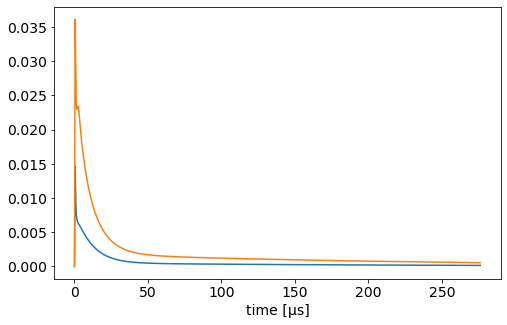

In [167]:
exc_F0 = pop_results[-4,:]
exc_F1 = pop_results[-3:,:].sum(axis = 0)

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(t_array, exc_F0)
ax.plot(t_array, exc_F1)

ax.set_xlabel('time [μs]')

set_fontsize(ax, 14)

In [168]:
np.trapz(exc_F0, t_array/1e6)*Γ

1.6547211752577726

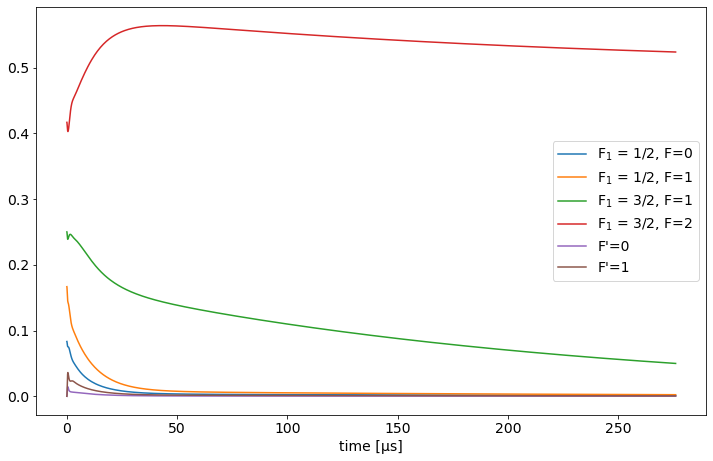

In [169]:
fig, ax = plt.subplots(figsize = (12,7.5))
ax.plot(t_array, pop_results[0,:], label = r'F$_1$ = 1/2, F=0')
ax.plot(t_array, np.sum(pop_results[1:3,:], axis = 0), label = r'F$_1$ = 1/2, F=1')
ax.plot(t_array, np.sum(pop_results[3:6,:], axis = 0), label = r'F$_1$ = 3/2, F=1')
ax.plot(t_array, np.sum(pop_results[6:11,:], axis = 0), label = r'F$_1$ = 3/2, F=2')
ax.plot(t_array, exc_F0, label = "F'=0")
ax.plot(t_array, exc_F1, label = "F'=1")

ax.set_xlabel('time [μs]')
ax.legend(fontsize = 14)
set_fontsize(ax, 14)

In [170]:
for s in QN:
    s.print_state()

+1.0000+0.0000j x |X, J = 1, F1 = 1/2, F = 0, mF = 0, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
+0.9961-0.0000j x |X, J = 1, F1 = 1/2, F = 1, mF = -1, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
+0.9961-0.0000j x |X, J = 1, F1 = 1/2, F = 1, mF = 0, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
+0.9961+0.0000j x |X, J = 1, F1 = 1/2, F = 1, mF = 1, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
+0.9961-0.0000j x |X, J = 1, F1 = 3/2, F = 1, mF = -1, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
+0.9961+0.0000j x |X, J = 1, F1 = 3/2, F = 1, mF = 0, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
+0.9961-0.0000j x |X, J = 1, F1 = 3/2, F = 1, mF = 1, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
+1.0000-0.0000j x |X, J = 1, F1 = 3/2, F = 2, mF = -2, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
+1.0000-0.0000j x |X, J = 1, F1 = 3/2, F = 2, mF = -1, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
+1.0000+0.0000j x |X, J = 1, F1 = 3/2, F = 2, mF = 0, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
+1.0000+0.0000j x |X, J = 1, F1 = 3/2, F = 2, mF = 1, I1 = 1/2, I2

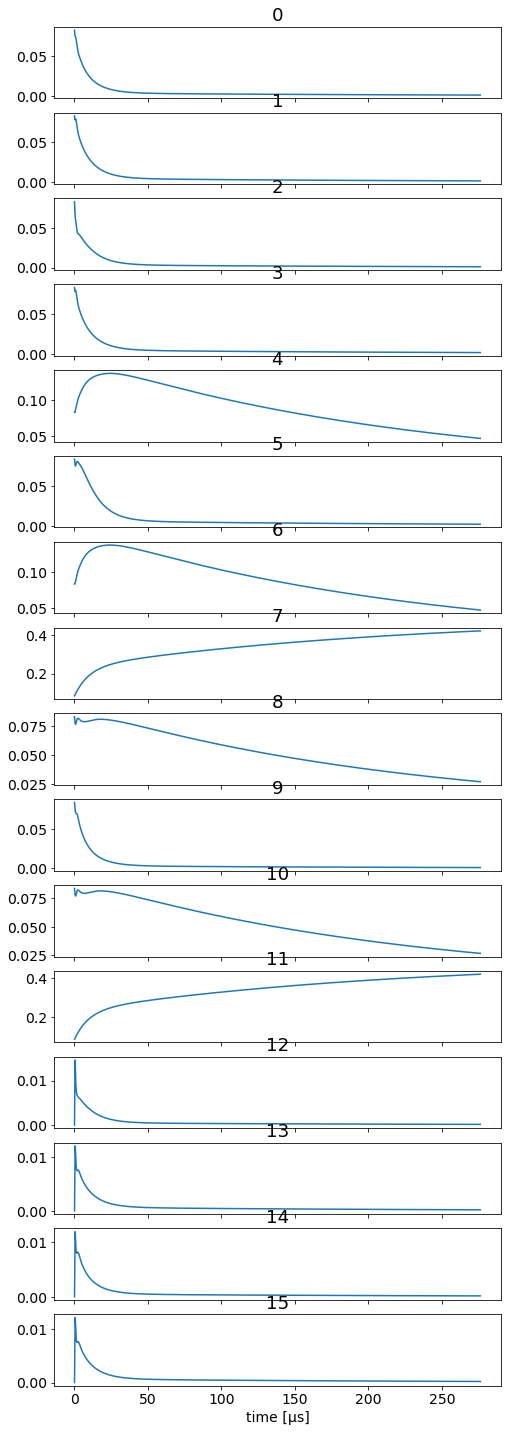

In [171]:
fig, axes = plt.subplots(figsize = (8,25), nrows = 16, sharex = True)
for idx, pop in enumerate(pop_results):
    axes[idx].plot(t_array, pop)
    axes[idx].set_title(idx)

axes[idx].set_xlabel('time [μs]')
for ax in axes:
    set_fontsize(ax, 14)

### Parameter scan for Δ

In [181]:
Main.eval("@everywhere params = [val*2pi*1e6 for val in range(-25,25,length=401)]")

In [182]:
# function called every time on the when an ODE solve is ready
# only save the integral of the excited state population of each trajectory
Main.eval(f"""
@everywhere function output_func(sol,i)
    # next!(pbar)
    return trapz(sol.t, [real(sum(diag(sol.u[j])[{n_states}])) for j in 1:size(sol.u)[1]]), false
end""")

In [183]:
Main.eval("""
tspan = (0.0f0, 300e-6)
prob = ODEProblem(Lindblad_rhs!,ρ_ini,tspan,p);
""");

 0.10Γ :  0.000 MHz offset
 0.20Γ :  0.250 MHz offset
 0.30Γ :  0.625 MHz offset
 0.40Γ :  0.875 MHz offset
 0.50Γ :  1.000 MHz offset
 0.60Γ :  1.125 MHz offset
 0.70Γ :  1.000 MHz offset
 0.80Γ :  0.625 MHz offset
 0.90Γ :  0.125 MHz offset
 1.00Γ : -0.500 MHz offset
Wall time: 5min 26s


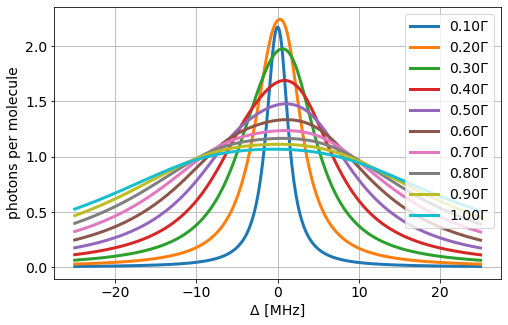

In [198]:
%%time

fig, ax = plt.subplots(figsize = (8,5))

for Ωi in np.linspace(0,1,11):
    # defining the function that changes the ODE parameters for each iteration
    Main.eval(f"""
    @everywhere function prob_func(prob,i,repeat)
        remake(prob,p=[{Ωi}Γ; params[i]; {Ωi}Γ; params[i]])
    end
    """)

    # setting up the EnsembleProblem with the earlier defined ODEProblem
    Main.eval("""
    ens_prob = EnsembleProblem(prob, prob_func = prob_func, output_func = output_func);
    """);

    Main.eval("""
    @time sim = solve(ens_prob, Tsit5(), EnsembleDistributed(), save_start = true, save_end = true, 
                save_everystep = true; trajectories = size(params)[1], dt = 1e-9, adaptive=true,
                abstol = 1e-11, reltol = 1e-8)
    sim.elapsedTime
    """)
    
    results_Δs = Main.eval("sim.u")
    if Ωi != 0:
        l = ax.plot(Main.params/(2*np.pi*1e6), results_Δs*Γ, lw = 3, label = f'{Ωi:.2f}Γ')
        center = Main.params[np.argmax(results_Δs)]/(2*np.pi*1e6)
#         ax.axvline(center, color = l[0].get_color(), lw = 2)
        print(f"{Ωi:>5.2f}Γ : {center:>6.3f} MHz offset")
ax.set_xlabel('Δ [MHz]')
ax.set_ylabel('photons per molecule')
ax.grid(True)
set_fontsize(ax, 14)
ax.legend(fontsize = 14)